
# IHEPC — Notebook de Tarefas (estilo *Cópia_de_NovoSERS*)

> Data de geração: 2025-09-01 18:28

Este notebook segue a mesma **pegada** do arquivo *Cópia_de_NovoSERS.ipynb*, com tarefas
comentadas e resolvidas passo a passo para o dataset **Individual household electric power consumption**.


## Parte 0 — Setup & Carregamento

In [20]:

# Parâmetros principais
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.txt"
data_path = "./household_power_consumption.txt"  # altere se necessário
out_dir = "./_out"

import os, io, sys, zipfile, urllib.request, pandas as pd, numpy as np, matplotlib.pyplot as plt
os.makedirs(out_dir, exist_ok=True)

print("Versões:")
import platform
print("Python:", platform.python_version())
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)


Versões:
Python: 3.12.11
Pandas: 2.2.2
Numpy: 2.0.2


In [3]:

# Tarefa 0.1 — Garantir disponibilidade do arquivo local (download se não existir)
if not os.path.exists(data_path):
    try:
        print("Baixando dataset da UCI...")
        urllib.request.urlretrieve(data_url, data_path)
        print("Download concluído:", data_path)
    except Exception as e:
        print("Falha no download automático:", e)
        print("Faça o download manual e ajuste 'data_path'.")


In [4]:

# Tarefa 0.2 — Carregar dados crus
# Observação: o arquivo é grande. Use low_memory=False para evitar inferência parcial de tipos.
raw = pd.read_csv(
    data_path,
    sep=';',
    low_memory=False
)
print(raw.shape)
raw.head(3)


(1074947, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0


## Parte 1 — Limpeza e Entendimento

In [5]:

# Tarefa 1.1 — Tipos de dados iniciais
raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074947 entries, 0 to 1074946
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1074947 non-null  object 
 1   Time                   1074947 non-null  object 
 2   Global_active_power    1074947 non-null  object 
 3   Global_reactive_power  1074947 non-null  object 
 4   Voltage                1074947 non-null  object 
 5   Global_intensity       1074947 non-null  object 
 6   Sub_metering_1         1074947 non-null  object 
 7   Sub_metering_2         1074947 non-null  object 
 8   Sub_metering_3         1070877 non-null  float64
dtypes: float64(1), object(8)
memory usage: 73.8+ MB


In [6]:

# Tarefa 1.2 — Combinar Date + Time em coluna datetime e converter numéricos
df = raw.copy()

# 1) datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# 2) converter colunas numéricas
num_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# 3) ordenar por tempo e descartar linhas sem datetime
df = df.dropna(subset=['Datetime']).sort_values('Datetime').reset_index(drop=True)

print(df[num_cols].isna().sum())
df.head(3)


Global_active_power      4070
Global_reactive_power    4070
Voltage                  4070
Global_intensity         4070
Sub_metering_1           4070
Sub_metering_2           4070
Sub_metering_3           4070
dtype: int64


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00


In [7]:

# Tarefa 1.3 — Estatísticas descritivas e % de ausentes
desc = df[num_cols].describe().T
na_pct = df[num_cols].isna().mean().mul(100).round(3)
desc['missing_%'] = na_pct
desc


,count,mean,std,min,25%,50%,75%,max,missing_%
Global_active_power,1070877.0,1.110850,1.127497,0.076,0.29,0.556,1.548,10.67,0.379
Global_reactive_power,1070877.0,0.117514,0.109166,0.000,0.00,0.098,0.184,1.39,0.379
Voltage,1070877.0,240.039286,3.311528,223.490,238.03,240.270,242.230,252.14,0.379
Global_intensity,1070877.0,4.726315,4.753550,0.200,1.20,2.400,6.400,46.40,0.379
Sub_metering_1,1070877.0,1.171742,6.306103,0.000,0.00,0.000,0.000,80.00,0.379
Sub_metering_2,1070877.0,1.461439,6.335066,0.000,0.00,0.000,1.000,78.00,0.379
Sub_metering_3,1070877.0,5.943706,8.219286,0.000,0.00,0.000,17.000,31.00,0.379


In [8]:

# Tarefa 1.4 — Estratégia de imputação simples (forward fill) para séries temporais
df[num_cols] = df[num_cols].fillna(method='ffill')
# Se ainda restarem NaNs no início, backfill
df[num_cols] = df[num_cols].fillna(method='bfill')

assert df[num_cols].isna().sum().sum() == 0, "Ainda há NaNs após imputação."
df.head(3)


/tmp/ipython-input-1437219198.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[num_cols] = df[num_cols].fillna(method='ffill')
/tmp/ipython-input-1437219198.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[num_cols] = df[num_cols].fillna(method='bfill')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00


## Parte 2 — Exploração Temporal

In [9]:

# Tarefa 2.1 — Definir índice temporal e janela do período
df = df.set_index('Datetime')
start, end = df.index.min(), df.index.max()
print("Período:", start, "->", end)
df[['Global_active_power']].head(3)


Período: 2006-12-16 17:24:00 -> 2009-01-01 05:10:00


,Global_active_power
Datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374


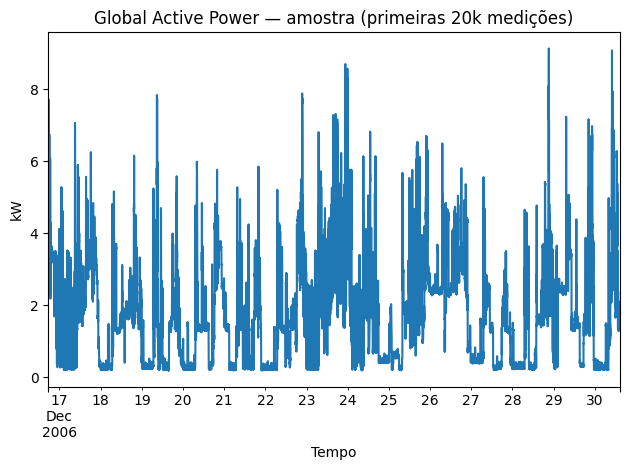

In [10]:

# Tarefa 2.2 — Série de Global_active_power (amostra para performance)
sample = df['Global_active_power'].iloc[:20000]
plt.figure()
sample.plot(title="Global Active Power — amostra (primeiras 20k medições)")
plt.xlabel("Tempo")
plt.ylabel("kW")
plt.tight_layout()
plt.show()


In [11]:

# Tarefa 2.3 — Resample para hora e dia
hourly = df.resample('H').mean(numeric_only=True)
daily = df.resample('D').mean(numeric_only=True)
print(hourly.shape, daily.shape)
daily.head(3)


(17917, 7) (748, 7)


/tmp/ipython-input-2981040807.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df.resample('H').mean(numeric_only=True)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722


In [12]:

# Tarefa 2.4 — Correlação entre variáveis principais (diário)
corr = daily[['Global_active_power','Global_reactive_power','Voltage','Global_intensity',
              'Sub_metering_1','Sub_metering_2','Sub_metering_3']].corr()
corr.round(3)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000,0.112,0.151,0.999,0.509,0.472,0.767
Global_reactive_power,0.112,1.000,-0.142,0.131,0.407,0.203,0.090
Voltage,0.151,-0.142,1.000,0.130,-0.085,-0.041,0.120
Global_intensity,0.999,0.131,0.130,1.000,0.519,0.478,0.764
Sub_metering_1,0.509,0.407,-0.085,0.519,1.000,0.209,0.331
Sub_metering_2,0.472,0.203,-0.041,0.478,0.209,1.000,0.290
Sub_metering_3,0.767,0.090,0.120,0.764,0.331,0.290,1.000


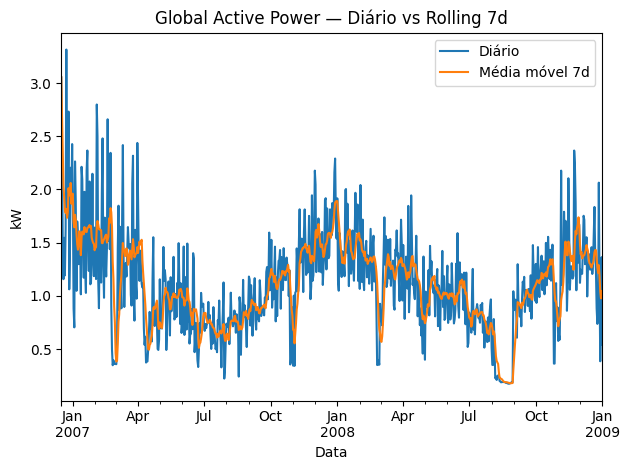

In [13]:

# Tarefa 2.5 — Rolling mean de 7 dias em Global_active_power
roll7 = daily['Global_active_power'].rolling(7, min_periods=1).mean()
plt.figure()
daily['Global_active_power'].plot(label='Diário')
roll7.plot(label='Média móvel 7d')
plt.title("Global Active Power — Diário vs Rolling 7d")
plt.legend()
plt.xlabel("Data")
plt.ylabel("kW")
plt.tight_layout()
plt.show()


## Parte 3 — Agregações & Perfis de Consumo

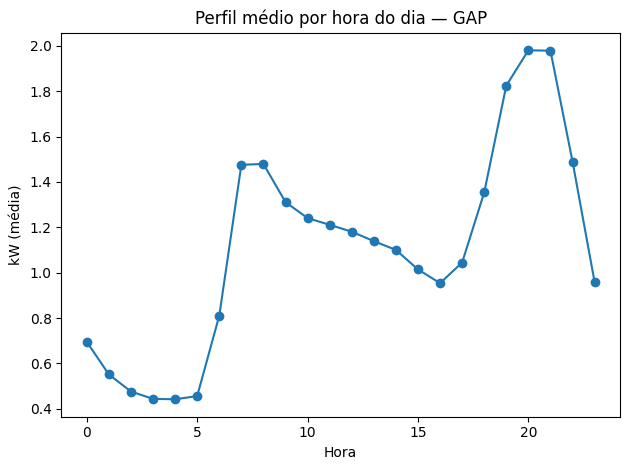

,Global_active_power
Datetime,
0,0.6954
1,0.5516
2,0.4764
3,0.4440
4,0.4423
5,0.4563
6,0.8103
7,1.4754
8,1.4791


In [14]:

# Tarefa 3.1 — Perfil por hora do dia (média ao longo de todo o período)
hour_profile = df.groupby(df.index.hour)['Global_active_power'].mean()
plt.figure()
hour_profile.plot(kind='line', marker='o', title="Perfil médio por hora do dia — GAP")
plt.xlabel("Hora")
plt.ylabel("kW (média)")
plt.tight_layout()
plt.show()
hour_profile.round(4)


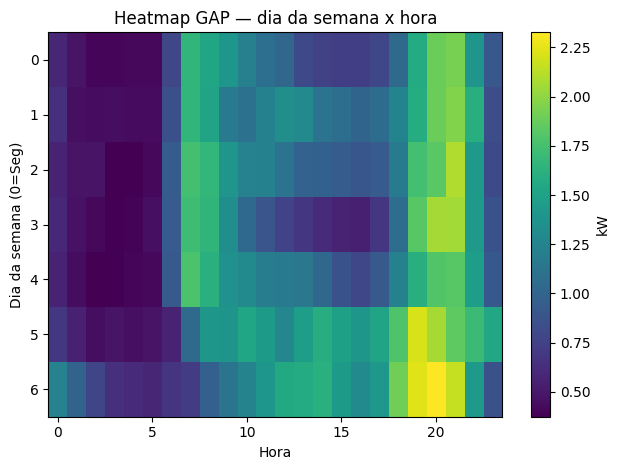

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
0,0.582,0.474,0.401,0.406,0.419,0.419,0.787,1.659,1.527,1.403,...,0.755,0.734,0.733,0.788,1.049,1.576,1.890,1.923,1.393,0.903
1,0.634,0.454,0.440,0.443,0.434,0.429,0.850,1.663,1.511,1.188,...,1.119,1.083,1.005,1.061,1.255,1.579,1.891,1.958,1.600,0.832
2,0.563,0.473,0.473,0.380,0.380,0.418,0.941,1.740,1.665,1.394,...,0.983,0.940,0.893,0.932,1.173,1.744,1.828,2.094,1.420,0.804
3,0.591,0.469,0.414,0.378,0.393,0.450,0.934,1.718,1.653,1.327,...,0.608,0.561,0.549,0.685,1.071,1.820,2.062,2.058,1.424,0.864
4,0.566,0.438,0.374,0.379,0.411,0.416,0.922,1.772,1.616,1.359,...,1.037,0.865,0.788,0.918,1.231,1.608,1.798,1.818,1.462,0.912
5,0.691,0.553,0.450,0.477,0.451,0.476,0.568,1.052,1.410,1.384,...,1.590,1.483,1.405,1.515,1.785,2.206,2.062,1.841,1.703,1.541
6,1.239,0.999,0.782,0.645,0.609,0.586,0.669,0.724,0.974,1.124,...,1.610,1.434,1.305,1.412,1.906,2.235,2.327,2.155,1.425,0.855


In [15]:

# Tarefa 3.2 — Semana: dia da semana vs hora (mapa de calor em pivot)
import numpy as np
temp = df[['Global_active_power']].copy()
temp['weekday'] = df.index.weekday  # 0=Seg, 6=Dom
temp['hour'] = df.index.hour
pivot = temp.pivot_table(index='weekday', columns='hour', values='Global_active_power', aggfunc='mean')

plt.figure()
plt.imshow(pivot.values, aspect='auto')
plt.title("Heatmap GAP — dia da semana x hora")
plt.xlabel("Hora")
plt.ylabel("Dia da semana (0=Seg)")
plt.colorbar(label="kW")
plt.tight_layout()
plt.show()
pivot.round(3)


<Figure size 640x480 with 0 Axes>

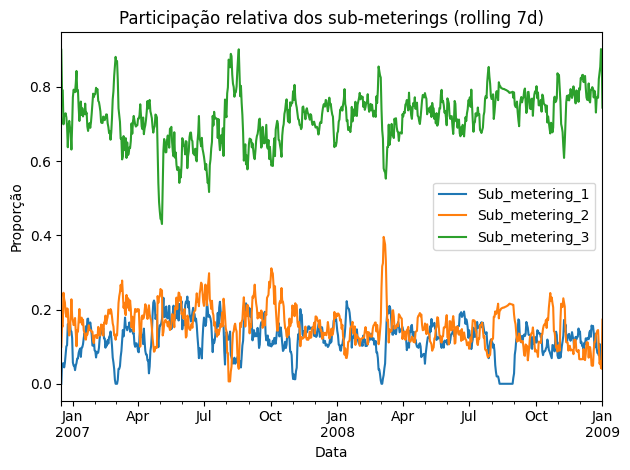

,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,
2008-12-30,0.000,0.033,0.967
2008-12-31,0.197,0.016,0.786
2009-01-01,0.000,1.000,0.000


In [16]:

# Tarefa 3.3 — Energia submetering: participação relativa (diário)
sub_daily = daily[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].clip(lower=0)
sub_share = sub_daily.div(sub_daily.sum(axis=1), axis=0).fillna(0)

plt.figure()
sub_share.rolling(7, min_periods=1).mean().plot()
plt.title("Participação relativa dos sub-meterings (rolling 7d)")
plt.xlabel("Data")
plt.ylabel("Proporção")
plt.tight_layout()
plt.show()

sub_share.tail(3).round(3)


In [17]:

# Tarefa 3.4 — Detecção simples de outliers em Voltage (IQR)
q1, q3 = daily['Voltage'].quantile([0.25, 0.75])
iqr = q3 - q1
low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
outliers = daily[(daily['Voltage'] < low) | (daily['Voltage'] > high)]
print("Outliers de Voltage (diário):", outliers.shape[0])
outliers.head()


Outliers de Voltage (diário): 89


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-27,1.061639,0.124237,243.767361,4.517500,0.000000,0.218056,4.844444
2007-04-24,0.716736,0.093933,235.344924,3.144861,0.781250,0.365972,4.638889
2007-04-25,0.877890,0.114400,234.941111,3.858056,0.000000,1.020139,6.119444
2007-04-26,0.885740,0.113615,234.787299,3.923750,0.919444,1.281250,4.974306


## Parte 4 — Baseline de Modelagem & Exportação

In [18]:

# Tarefa 4.1 — Regressão linear simples para prever GAP horário a partir de Voltage e GI
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

X = hourly[['Voltage','Global_intensity']].dropna()
y = hourly['Global_active_power'].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
lr = LinearRegression().fit(X_train, y_train)
pred = lr.predict(X_test)

print("R2:", r2_score(y_test, pred))
print("MAE:", mean_absolute_error(y_test, pred))
print("Coeficientes:", dict(zip(X.columns, lr.coef_)))


R2: 0.9992978403675944
MAE: 0.018910344628214282
Coeficientes: {'Voltage': np.float64(0.004176628712283368), 'Global_intensity': np.float64(0.23887003648229546)}


In [21]:

# Tarefa 4.2 — Salvar versões tratadas
daily_out = os.path.join(out_dir, "ihepc_daily.csv")
hourly_out = os.path.join(out_dir, "ihepc_hourly.csv")
df_daily = daily.copy()
df_hourly = hourly.copy()
df_daily.to_csv(daily_out)
df_hourly.to_csv(hourly_out)
daily_out, hourly_out


('./_out/ihepc_daily.csv', './_out/ihepc_hourly.csv')